# Healthcare Appointment No-Show Prediction with Logistic Regression

## Introduction

Missed medical appointments ("no-shows") are a common issue in healthcare, leading to wasted resources and reduced quality of care. Being able to predict whether a patient will attend their appointment can help hospitals improve planning, efficiency, and patient outcomes.

In this project, we use the [**Healthcare Appointment No-Show Dataset from Kaggle**](https://www.kaggle.com/datasets/wajahat1064/healthcare-appointment-dataset), which contains details about patients’ appointments (age, gender, medical conditions, appointment dates, SMS reminders, etc.) along with whether they actually showed up. Our task is to build a model that predicts the likelihood of a **no-show**.

Because this is a **binary classification problem**, we will use **Logistic Regression** as our main modeling approach. Specifically, we will experiment with:
- **Standard Logistic Regression**  
- **Logistic Regression with L1 (Lasso) and L2 (Ridge) regularization**  
- **LogisticRegressionCV** with cross-validation to find the best regularization strength  

We will evaluate model performance using key classification metrics:
- **Accuracy** – overall correctness  
- **Precision** – correctness of predicted no-shows  
- **Recall** – ability to detect actual no-shows  
- **F1 Score** – balance between precision and recall  

This notebook will be beginner-friendly, with clear explanations, commented code, and documented functions. By the end, we’ll understand how logistic regression can be applied to healthcare data and how to interpret its results.

## 1. Importing Libraries

We start by importing the Python libraries needed for data handling, visualization, and modeling.

In [1]:
# Utilities
import warnings

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and Evaluations
from scipy.stats import levene, ttest_ind, chi2_contingency
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
sns.set(style='white')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.5

## 2. Importing and Previewing the Dataset

Next, we load the **Healthcare Appointment No-Show** dataset into a Pandas DataFrame.  
Previewing the data helps us understand the structure of the dataset, the number of rows, columns, feature names, and a quick look at the first few entries. This step gives us a sense of what kind of preprocessing or cleaning might be needed before modeling.


In [2]:
# Import and preview a few rows
data = pd.read_csv("healthcare_noshows.csv")
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,2.987250e+13,5642903,F,29/04/2016,29/04/2016,62,JARDIM DA PENHA,False,True,False,False,False,False,True,0
1,5.589980e+14,5642503,M,29/04/2016,29/04/2016,56,JARDIM DA PENHA,False,False,False,False,False,False,True,0
2,4.262960e+12,5642549,F,29/04/2016,29/04/2016,62,MATA DA PRAIA,False,False,False,False,False,False,True,0
3,8.679510e+11,5642828,F,29/04/2016,29/04/2016,8,PONTAL DE CAMBURI,False,False,False,False,False,False,True,0
4,8.841190e+12,5642494,F,29/04/2016,29/04/2016,56,JARDIM DA PENHA,False,True,True,False,False,False,True,0


In [3]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       106987 non-null  float64
 1   AppointmentID   106987 non-null  int64  
 2   Gender          106987 non-null  object 
 3   ScheduledDay    106987 non-null  object 
 4   AppointmentDay  106987 non-null  object 
 5   Age             106987 non-null  int64  
 6   Neighbourhood   106987 non-null  object 
 7   Scholarship     106987 non-null  bool   
 8   Hipertension    106987 non-null  bool   
 9   Diabetes        106987 non-null  bool   
 10  Alcoholism      106987 non-null  bool   
 11  Handcap         106987 non-null  bool   
 12  SMS_received    106987 non-null  bool   
 13  Showed_up       106987 non-null  bool   
 14  Date.diff       106987 non-null  int64  
dtypes: bool(7), float64(1), int64(3), object(4)
memory usage: 7.2+ MB


## 3. Data Cleaning

Before building our model, we need to clean the dataset. This involves:

- Removing duplicate records (if any)
- Checking for missing values
- Dropping unnecessary columns (identifiers)
- Correcting data types where needed

This step ensures the dataset is consistent and ready for analysis and modeling.

### 3.1 Checking for duplicates

In [4]:
print(f'Duplicates: {data.duplicated().sum()}')

Duplicates: 0


### 3.2 Check for missing values

In [5]:
print(f'Missing Values: {data.isnull().sum().sum()}')

Missing Values: 0


### 3.3 Drop unnecessary columns

In [6]:
# Drop the identifier columns
data = data.drop(columns=['PatientId', 'AppointmentID'])

### 3.4 Fix datatypes

In [7]:
# Convert date columns
date_cols = ['AppointmentDay', 'ScheduledDay']
data[date_cols] = data[date_cols].apply(pd.to_datetime, dayfirst=True)

### 3.5 Check for inconsistencies

In [8]:
# Utility function
def get_column_types(data: pd.DataFrame):
    """
    Identify and separate columns of a DataFrame by data type.

    Parameters
    ----------
    data : pd.DataFrame
        The input DataFrame.

    Returns
    -------
    dict
        A dictionary with keys:
        - 'numeric' : list of numeric column names (int, float)
        - 'categorical' : list of object or category column names
        - 'datetime' : list of datetime column names
        - 'boolean' : list of boolean column names
    """
    column_types = {
        'numeric': data.select_dtypes(include=['int64', 'float64']).columns.tolist(),
        'categorical': data.select_dtypes(include=['object', 'category']).columns.tolist(),
        'datetime': data.select_dtypes(include=['datetime64']).columns.tolist(),
        'boolean': data.select_dtypes(include=['bool']).columns.tolist()
    }

    return column_types

In [9]:
# Retrieve categorical columns
column_types = get_column_types(data=data)
categorical_cols = column_types['categorical'] + column_types['boolean']

# Preview unique values
for col in categorical_cols:
    unique_values = data[col].unique()
    print(f'=== {col} ===')
    print(unique_values, '\n')

=== Gender ===
['F' 'M'] 

=== Neighbourhood ===
['JARDIM DA PENHA' 'MATA DA PRAIA' 'PONTAL DE CAMBURI' 'REPÚBLICA'
 'GOIABEIRAS' 'ANDORINHAS' 'CONQUISTA' 'NOVA PALESTINA' 'DA PENHA'
 'TABUAZEIRO' 'BENTO FERREIRA' 'SÃO PEDRO' 'SANTA MARTHA' 'SÃO CRISTÓVÃO'
 'MARUÍPE' 'GRANDE VITÓRIA' 'SANTO ANDRÉ' 'SOLON BORGES' 'BONFIM'
 'JARDIM CAMBURI' 'MARIA ORTIZ' 'JABOUR' 'ANTÔNIO HONÓRIO' 'RESISTÊNCIA'
 'ILHA DE SANTA MARIA' 'JUCUTUQUARA' 'MÁRIO CYPRESTE' 'SANTO ANTÔNIO'
 'BELA VISTA' 'PRAIA DO SUÁ' 'SANTA HELENA' 'ITARARÉ' 'INHANGUETÁ'
 'UNIVERSITÁRIO' 'SÃO JOSÉ' 'REDENÇÃO' 'SANTA CLARA' 'CENTRO'
 'PARQUE MOSCOSO' 'DO MOSCOSO' 'SANTOS DUMONT' 'CARATOÍRA'
 'ARIOVALDO FAVALESSA' 'ILHA DO FRADE' 'GURIGICA' 'JOANA D´ARC'
 'CONSOLAÇÃO' 'SÃO BENEDITO' 'PRAIA DO CANTO' 'BOA VISTA' 'SANTA LÚCIA'
 'BARRO VERMELHO' 'ESTRELINHA' 'FORTE SÃO JOÃO' 'FONTE GRANDE'
 'MORADA DE CAMBURI' 'ENSEADA DO SUÁ' 'SANTOS REIS' 'PIEDADE'
 'JESUS DE NAZARETH' 'SANTA LUÍZA' 'SANTA TEREZA' 'CRUZAMENTO'
 'ILHA DO PRÍNCIPE' 'R

In [10]:
# Rename columns
col_names_dict = {
    'Hipertension': 'Hypertension',
    'Handcap': 'Handicap'
}

data = data.rename(columns=col_names_dict)

## 4. Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand patterns, distributions, and relationships that may influence whether a patient shows up for their appointment. We will start by examining the target variable distribution, then look at demographic features (`age`, `gender`), medical conditions, appointment timing, and the role of social and neighborhood factors. This step provides valuable insights that guide both data preprocessing and model building.

### 4.1 Target Variable Distribution

The target variable in this dataset is `Showed_up`, which indicates whether a patient showed up for their appointment.  
- `0` → The patient showed up.  
- `1` → The patient did not show up.  

Before building predictive models, it’s important to understand the class balance. If one class dominates, it may bias the model and affect evaluation metrics.

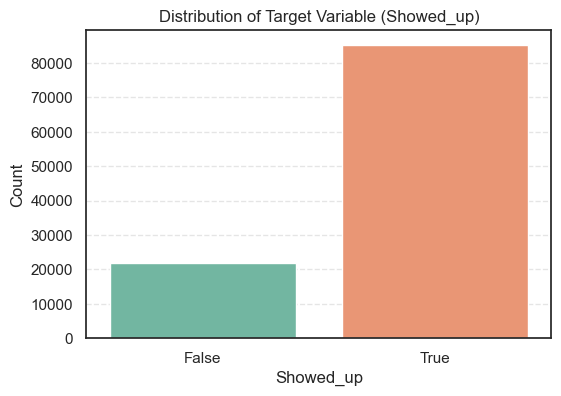

In [11]:
# Distribution of the target variable (Showed_up)
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Showed_up', palette='Set2')
plt.title('Distribution of Target Variable (Showed_up)')
plt.xlabel("Showed_up")
plt.ylabel("Count")
plt.show()

In [12]:
# Count summary of the target variable (Showed_up)
data['Showed_up'].value_counts().to_frame(name='Count').assign(
    Percent=lambda x: round((x['Count'] / x['Count'].sum()) * 100, 2))

,Count,Percent
Showed_up,,
True,85307,79.74
False,21680,20.26


From the distribution of the target variable, we observe:  

- **Showed Up (True):** 85,307 patients (~79.7%)  
- **Did Not Show (False):** 21,680 patients (~20.3%)  

This indicates that the dataset is **imbalanced**, with the majority of patients attending their appointments.  

**Implication**: When building predictive models, this imbalance means that a simple model predicting “showed up” for everyone would already achieve ~80% accuracy. Therefore, we must evaluate our models using additional metrics such as **precision, recall, and F1-score** to get a fair picture of performance, especially for the minority class (`Showed_up = False`).

### 4.2 EDA on Numerical Variables

We begin by exploring numerical variables individually to understand their distributions and possible anomalies. Then, we analyze how these variables relate to the target variable (`Showed_up`) to identify potential predictors of appointment attendance.

#### 4.2.1 Univariate Numerical Analysis

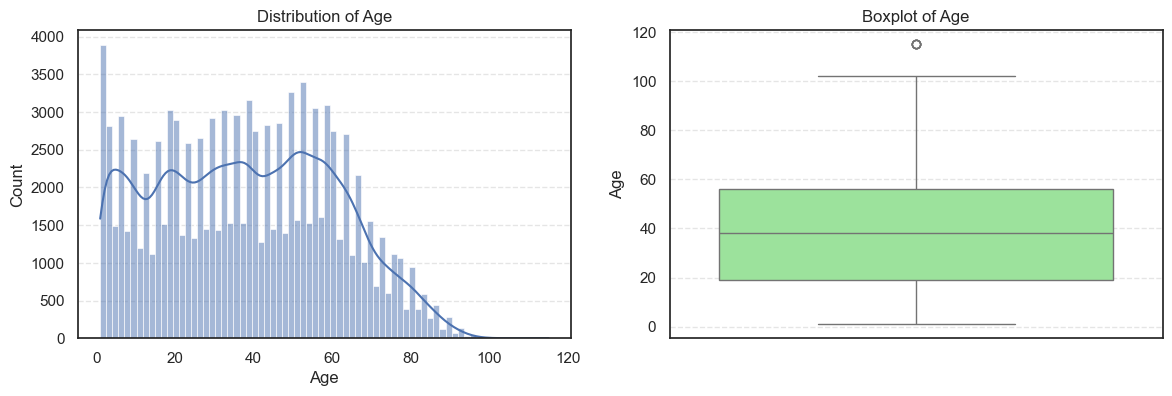

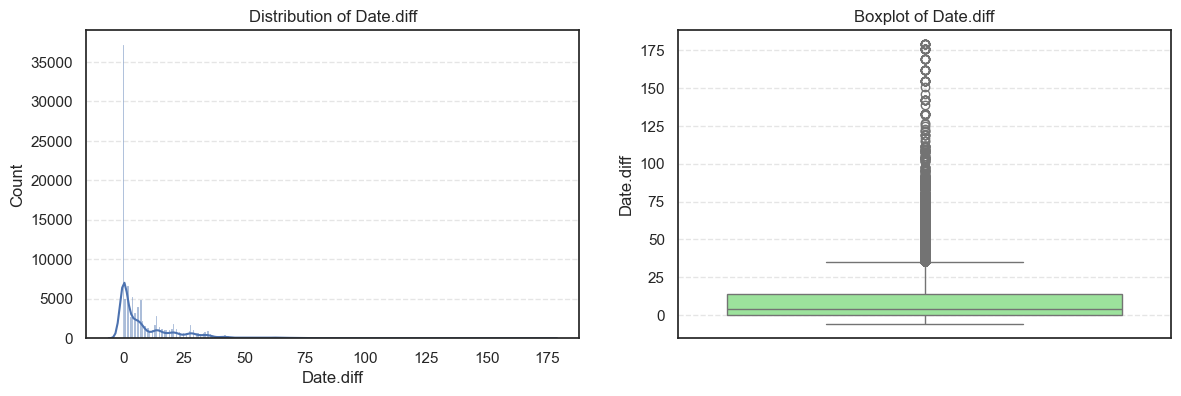

In [13]:
# Distribution of Numerical Variables
column_types = get_column_types(data=data)
numerical_cols = column_types['numeric']

for i, col in enumerate(numerical_cols, 1):
    plt.figure(figsize=(14, 4))
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=data, x=col, kde=True)
    plt.title(f'Distribution of {col}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=data, y=col, color='lightgreen')
    plt.title(f'Boxplot of {col}')
plt.show()

In [14]:
# Statistical information of numerical variables
data.describe(include=['int64', 'float64'])

,Age,Date.diff
count,106987.000000,106987.000000
mean,38.316085,10.166721
std,22.466214,15.263508
min,1.000000,-6.000000
25%,19.000000,0.000000
50%,38.000000,4.000000
75%,56.000000,14.000000
max,115.000000,179.000000


In [15]:
# Outliers and Skew of numerical variables
for col in numerical_cols:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - iqr * 1.5
    upper = q3 + iqr * 1.5
    outliers = data[(data[col] < lower) | (data[col] > upper)][col]
    print(f'=== {col} ===')
    print(f'Outliers: {len(outliers)}')
    print(f'Skew: {data[col].skew()}', '\n')

=== Age ===
Outliers: 5
Skew: 0.12164402331150703 

=== Date.diff ===
Outliers: 6489
Skew: 2.6901608800185848 



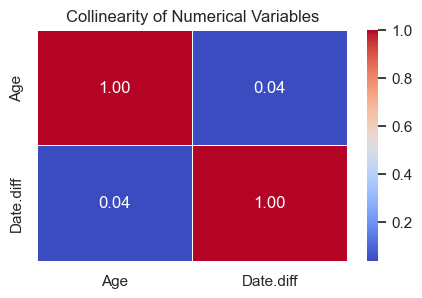

In [16]:
# Check for collinearity
corr_mat = data[numerical_cols].corr()
plt.figure(figsize=(5, 3))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Collinearity of Numerical Variables')
plt.show()

**Numerical Variables Analysis**

We analyzed the two main continuous numerical variables in the dataset: **Age** and **Date.diff** (days between scheduling and appointment).

`Age` 
- Ranges from **1 to 115 years**, which is reasonable for patient data.  
- Only **5 outliers** were detected, which is very small relative to the dataset size (~107k rows).  
- The distribution is nearly symmetric (**skew ≈ 0.12**), suggesting no significant skewness.  
- Median age is **38 years**, with most patients falling between **19 and 56 years** (IQR).  

`Date.diff`
- Represents the number of days between scheduling and appointment.  
- Values range from **-6 to 179 days**. The negative values are suspicious (an appointment date before the scheduling date) and likely represent **data quality issues**.  
- About **6,489 outliers** were identified, which is notable.  
- The distribution is **right-skewed (skew ≈ 2.69)**, meaning most patients are scheduled within a short time window, but a few are scheduled far in advance.  
- Median wait time is **4 days**, and 75% of appointments are within **14 days**.  

**Key Takeaways**  
- `Age` is a well-behaved variable and can be directly used in modeling.  
- `Date.diff` requires cleaning (e.g., handling negative values, possibly capping extreme outliers).  
- Since `Date.diff` is heavily skewed, we may later consider **log transformation** or **binning** to stabilize its distribution.
- There is no collinearity between the two variables.

#### 4.2.2 Numerical Variables vs Target `Showed_up`

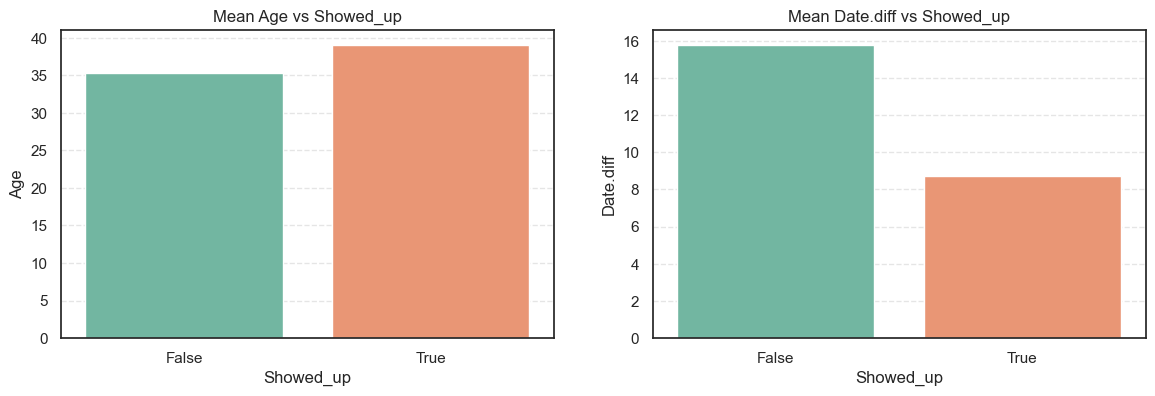

In [17]:
# Plot mean of numerical variables vs Showed_up
plt.figure(figsize=(14, 4))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 2, i)
    sns.barplot(data=data, x='Showed_up', y=col, palette='Set2', estimator='mean', ci=None)
    plt.title(f'Mean {col} vs Showed_up')
    plt.xlabel("Showed_up")
    plt.ylabel(col)
plt.show()

In [18]:
# Calculate mean of numerical variables vs Showed_up
for col in numerical_cols:
    mean_show_up = data.groupby('Showed_up')[col].mean().to_frame(name='Mean')
    print(f'=== {col} ===')
    print(mean_show_up, '\n')

=== Age ===
                Mean
Showed_up           
False      35.329151
True       39.075187 

=== Date.diff ===
                Mean
Showed_up           
False      15.789299
True        8.737794 



In [19]:
# T-Test
alpha = 0.05
for col in numerical_cols:
    showed_up = data[data['Showed_up'] == True][col]
    no_showed_up = data[data['Showed_up'] == False][col]

    _, lev_p = levene(showed_up, no_showed_up, center='median')
    equal_var = lev_p >= alpha
    t_stat, p_value = ttest_ind(showed_up, no_showed_up, equal_var=equal_var)

    print(f'=== {col} ===')
    print(f'T-Stat: {t_stat:.2f}, P-Value: {p_value:.4f}')

    test = 'Standard' if equal_var else 'Welch'
    print(f'Test: {test}')

    print(f'Null Hypothesis (Ho): Mean {col} is the same in showed up or no show.')
    decision = 'Reject Hypothesis' if p_value < alpha else 'Fail to reject hypothesis.'
    print(f'Decision: {decision}', '\n')

=== Age ===
T-Stat: 22.68, P-Value: 0.0000
Test: Welch
Null Hypothesis (Ho): Mean Age is the same in showed up or no show.
Decision: Reject Hypothesis 

=== Date.diff ===
T-Stat: -57.16, P-Value: 0.0000
Test: Welch
Null Hypothesis (Ho): Mean Date.diff is the same in showed up or no show.
Decision: Reject Hypothesis 



**Numerical Variables vs Target (`Showed_up`) Analysis**

We analyzed how the numerical features `Age` and `Date.diff` relate to whether patients attended their appointments.

**Summary of Findings**
- **Age:** The average age of patients who showed up was **around 39 years**, compared to **35 years** for those who did not.  
  → Older patients are generally more likely to attend their appointments.  
- **Date.diff:** The average waiting time (difference between scheduling and appointment date) was **about 9 days** for those who showed up and **16 days** for those who didn’t.  
  → Longer waiting periods significantly increase the likelihood of missing an appointment.

**Statistical Test Results**
- Both variables (`Age` and `Date.diff`) showed **p-values < 0.05** in Welch’s t-tests.  
  → This means the differences in means between “Showed” and “No-Show” groups are **statistically significant**.

**Overall:**  
`Age` and `Date.diff` both have a clear influence on appointment attendance. Older individuals and those with shorter scheduling gaps are more reliable in keeping their appointments.

### 4.3 EDA on Categorical Variables

We now explore the categorical features to understand their distributions and how they relate to the target variable (`Showed_up`). This analysis helps reveal behavioral and demographic patterns — such as gender, neighborhood, and participation in welfare programs — that may influence a patient’s likelihood of attending their appointment.

#### 4.3.1 Univariate Categorical Analysis

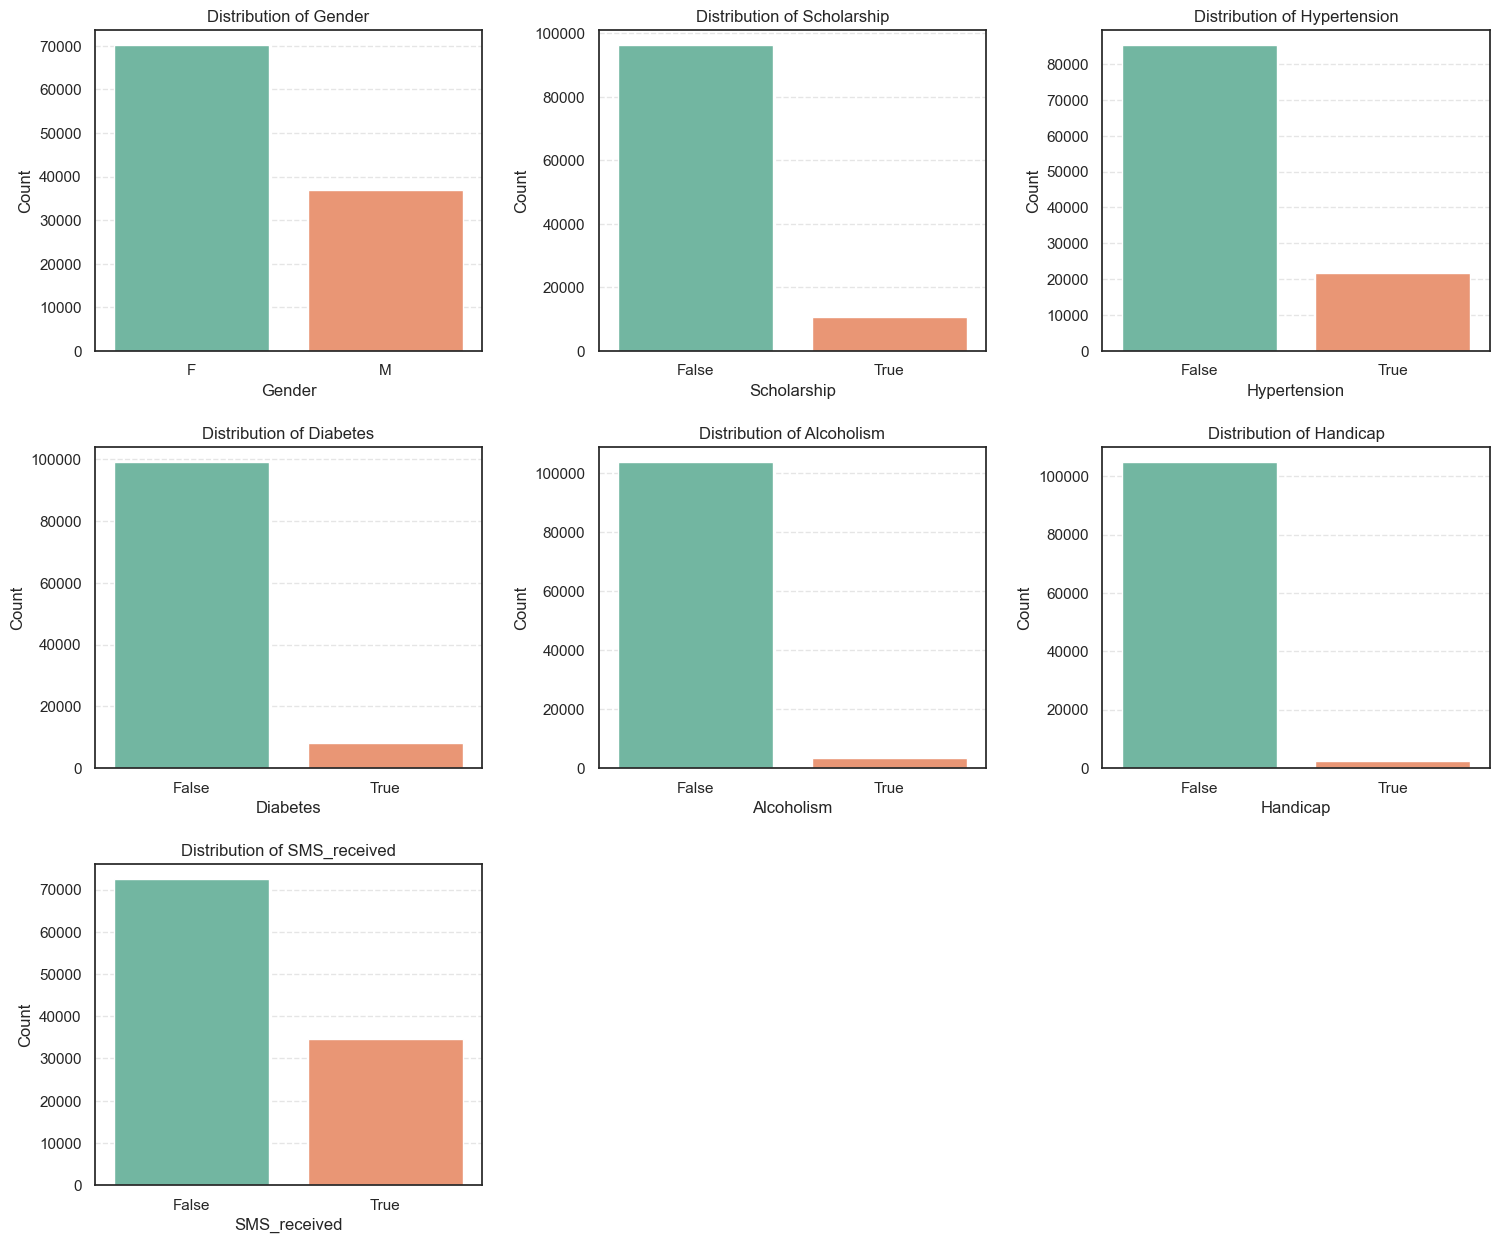

In [20]:
# Distribution of Categorical Variables
column_types = get_column_types(data=data)
categorical_cols = column_types['categorical'] + column_types['boolean']
categorical_cols.remove('Neighbourhood')
categorical_cols.remove('Showed_up')

n_cols = 3
n_rows = 3

plt.figure(figsize=(n_cols * 6, n_rows * 5))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=data, x=col, palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [21]:
# Statistical information of categorical variables
data.describe(include=['object', 'bool']).T

,count,unique,top,freq
Gender,106987,2,F,70118
Neighbourhood,106987,81,JARDIM CAMBURI,7586
Scholarship,106987,2,False,96178
Hypertension,106987,2,False,85186
Diabetes,106987,2,False,99044
Alcoholism,106987,2,False,103627
Handicap,106987,2,False,104747
SMS_received,106987,2,False,72402
Showed_up,106987,2,True,85307


In [22]:
# Count summary of the categorical variables
for col in categorical_cols:
    counts = data[col].value_counts().to_frame(name='Count').assign(
        Percent=lambda x: round((x['Count'] / x['Count'].sum()) * 100, 2))

    print(f'=== {col} ===')
    print(counts, '\n')

=== Gender ===
        Count  Percent
Gender                
F       70118    65.54
M       36869    34.46 

=== Scholarship ===
             Count  Percent
Scholarship                
False        96178     89.9
True         10809     10.1 

=== Hypertension ===
              Count  Percent
Hypertension                
False         85186    79.62
True          21801    20.38 

=== Diabetes ===
          Count  Percent
Diabetes                
False     99044    92.58
True       7943     7.42 

=== Alcoholism ===
             Count  Percent
Alcoholism                 
False       103627    96.86
True          3360     3.14 

=== Handicap ===
           Count  Percent
Handicap                 
False     104747    97.91
True        2240     2.09 

=== SMS_received ===
              Count  Percent
SMS_received                
False         72402    67.67
True          34585    32.33 



**Analysis of Categorical Variables**

We explored the categorical features to understand their frequency distributions and identify any imbalances or dominant categories.

- **Gender:** Majority of the patients are **female (65.5%)**, while males make up **34.5%**.  
- **Scholarship:** Only **10.1%** of patients are on a scholarship (likely indicating low-income support), showing a **large imbalance**.  
- **Hypertension:** About **20.4%** of patients have hypertension, while the majority **(79.6%)** do not.  
- **Diabetes:** Only **7.4%** of patients have diabetes, indicating it’s a **less common condition** in this dataset.  
- **Alcoholism:** Very few patients (**3.1%**) reported alcoholism, suggesting it may not be a strong factor in attendance.  
- **Handicap:** Only **2.1%** of patients have some form of handicap, another minority group.  
- **SMS_received:** Around **32.3%** of patients received an SMS reminder, while **67.7%** did not.

**Key Insights:**
- Most categorical features are **highly imbalanced**, with the “False” category dominating.  
- The imbalance may affect model learning, so **encoding and class weighting** should be considered later.  
- The **SMS_received** variable will be important to analyze against attendance, as reminders could influence show-up rates.

#### 4.3.2 Categorical Variables vs Target `Showed_up`

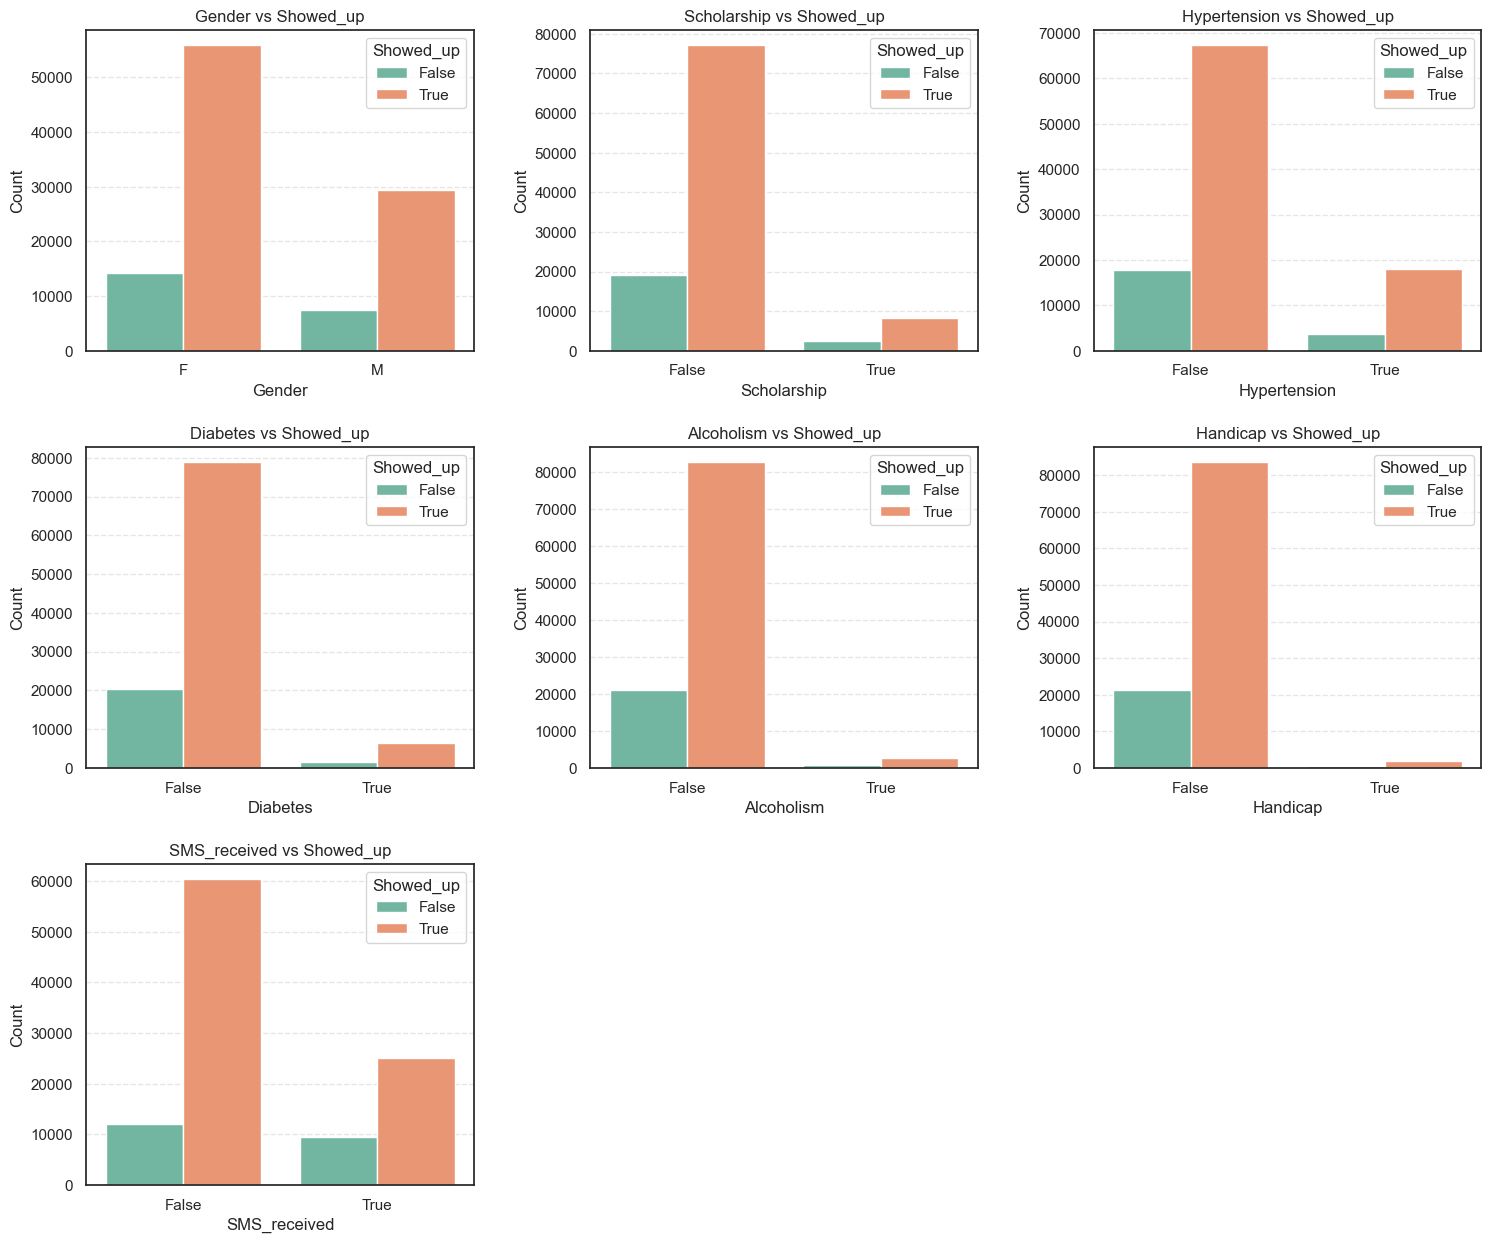

In [23]:
# Plot categorical variables vs the target (Showed_up)
n_cols = 3
n_rows = 3

plt.figure(figsize=(n_cols * 6, n_rows * 5))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=data, x=col, hue='Showed_up', palette='Set2')
    plt.title(f'{col} vs Showed_up')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [24]:
# Get the percentage of categorical variables vs the target (Showed_up)
for col in categorical_cols:
    summary = data.groupby(col)['Showed_up'].value_counts(normalize=True).unstack() * 100
    print(f'=== {col} ===')
    print(summary.round(2), '\n')

=== Gender ===
Showed_up  False  True 
Gender                 
F          20.36  79.64
M          20.08  79.92 

=== Scholarship ===
Showed_up    False  True 
Scholarship              
False        19.87  80.13
True         23.79  76.21 

=== Hypertension ===
Showed_up     False  True 
Hypertension              
False         21.02  78.98
True          17.30  82.70 

=== Diabetes ===
Showed_up  False  True 
Diabetes               
False      20.45  79.55
True       18.00  82.00 

=== Alcoholism ===
Showed_up   False  True 
Alcoholism              
False       20.27  79.73
True        20.15  79.85 

=== Handicap ===
Showed_up  False  True 
Handicap               
False      20.31  79.69
True       18.17  81.83 

=== SMS_received ===
Showed_up     False  True 
SMS_received              
False         16.73  83.27
True          27.67  72.33 



In [25]:
# Chi-Square Test
alpha = 0.05

for col in categorical_cols:
    cont_table = pd.crosstab(data[col], data['Showed_up'])
    stats, p_value, dof, expected_freq = chi2_contingency(cont_table)
    print(f'=== {col} ===')
    print(f'Stat: {stats:.2f}, P-Value: {p_value:.4f}')
    print(f'Null Hypothesis (Ho): There is no relation between {col} and Showed_up')
    decision = "Reject hypothesis" if p_value < alpha else "Fail to reject the hypothesis"
    print(f'Decision: {decision}', '\n')

=== Gender ===
Stat: 1.11, P-Value: 0.2931
Null Hypothesis (Ho): There is no relation between Gender and Showed_up
Decision: Fail to reject the hypothesis 

=== Scholarship ===
Stat: 92.04, P-Value: 0.0000
Null Hypothesis (Ho): There is no relation between Scholarship and Showed_up
Decision: Reject hypothesis 

=== Hypertension ===
Stat: 148.46, P-Value: 0.0000
Null Hypothesis (Ho): There is no relation between Hypertension and Showed_up
Decision: Reject hypothesis 

=== Diabetes ===
Stat: 26.99, P-Value: 0.0000
Null Hypothesis (Ho): There is no relation between Diabetes and Showed_up
Decision: Reject hypothesis 

=== Alcoholism ===
Stat: 0.02, P-Value: 0.8830
Null Hypothesis (Ho): There is no relation between Alcoholism and Showed_up
Decision: Fail to reject the hypothesis 

=== Handicap ===
Stat: 6.08, P-Value: 0.0137
Null Hypothesis (Ho): There is no relation between Handicap and Showed_up
Decision: Reject hypothesis 

=== SMS_received ===
Stat: 1731.81, P-Value: 0.0000
Null Hypothe

**Categorical Variables vs Target (`Showed_up`) Analysis**

This section explores how each categorical variable relates to appointment attendance. Both visual and statistical analyses (via Chi-Square tests) were used to determine significant relationships.

**Key Observations**

- **Gender**
  - Attendance rates are almost identical between females (79.64%) and males (79.92%).
  - **Chi-Square Test:** *p = 0.2931 → Fail to reject null hypothesis.*
  - **Inference:** Gender has no significant influence on attendance.

- **Scholarship**
  - Patients without a scholarship showed up more (80.13%) than those with a scholarship (76.21%).
  - **Chi-Square Test:** *p < 0.001 → Reject null hypothesis.*
  - **Inference:** There is a significant relationship — patients with scholarships tend to miss more appointments.

- **Hypertension**
  - Attendance is higher among hypertensive patients (82.70%) than non-hypertensive ones (78.98%).
  - **Chi-Square Test:** *p < 0.001 → Reject null hypothesis.*
  - **Inference:** Hypertensive patients are more likely to attend appointments.

- **Diabetes**
  - Diabetic patients have a slightly higher attendance rate (82%) than non-diabetics (79.55%).
  - **Chi-Square Test:** *p < 0.001 → Reject null hypothesis.*
  - **Inference:** Diabetes shows a mild but significant relationship with attendance.

- **Alcoholism**
  - Both groups have nearly identical attendance rates (~79.8%).
  - **Chi-Square Test:** *p = 0.8830 → Fail to reject null hypothesis.*
  - **Inference:** Alcoholism does not significantly affect appointment attendance.

- **Handicap**
  - Disabled patients have a slightly higher attendance rate (81.83%) than non-disabled ones (79.69%).
  - **Chi-Square Test:** *p = 0.0137 → Reject null hypothesis.*
  - **Inference:** Handicap status has a small but statistically significant association with attendance.

- **SMS_received**
  - Patients **without** an SMS reminder showed up more (83.27%) than those who **received** one (72.33%).
  - **Chi-Square Test:** *p < 0.001 → Reject null hypothesis.*
  - **Inference:** Surprisingly, SMS reminders are associated with *lower* attendance — possibly due to confounding factors like reminder timing or urgency of appointments.


**Overall Insights**

- Variables like **Scholarship**, **Hypertension**, **Diabetes**, **Handicap**, and **SMS_received** show statistically significant relationships with attendance.  
- **Gender** and **Alcoholism** have no meaningful impact.  
- The **SMS reminder finding** is counterintuitive and warrants deeper exploration — possibly through interaction effects or logistic regression.


## 5. Feature Engineering

In this section, we transform and create features to make the dataset more suitable for modeling.  
The goal is to improve the predictive power of our logistic regression models by ensuring that all variables are clean, relevant, and in a format the model can interpret.  

We will:

- Convert categorical and boolean variables into numerical form.  
- Derive new features that may capture useful patterns (e.g., waiting time between scheduling and appointment).  
- Drop or modify redundant or less informative columns. 

These transformations help prepare the data for efficient model training and improve the model’s ability to learn meaningful relationships.

### 5.1 Convert categorical and boolean variables into numerical form.

In [26]:
engineered_data = data.copy()

# Binary Encoding
binary_cols = ['Scholarship', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'Gender', 'Hypertension',
               'Showed_up']
replace_dict = {
    True: 1,
    False: 0,
    'M': 1,
    'F': 0
}

engineered_data[binary_cols] = engineered_data[binary_cols].replace(replace_dict)
engineered_data.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Showed_up,Date.diff
0,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0
1,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0
2,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0
3,0,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0
4,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0


### 5.2 Derive new features

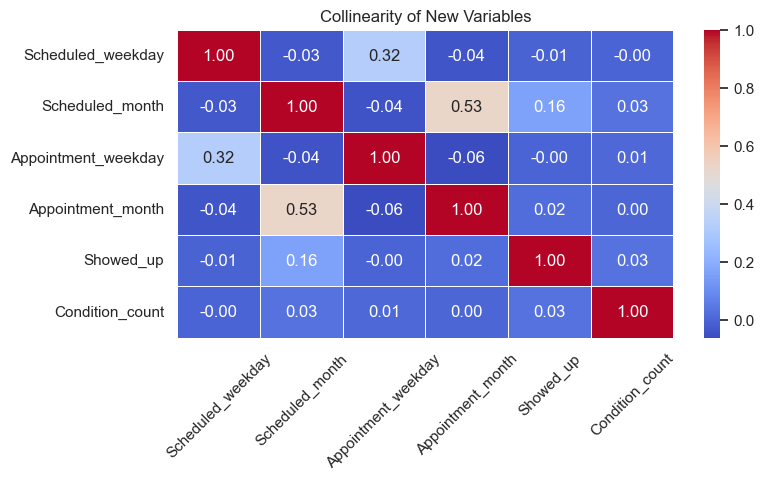

In [27]:
# Feature engineer and encode dates
engineered_data['Scheduled_weekday'] = pd.to_datetime(data['ScheduledDay']).dt.dayofweek
engineered_data['Scheduled_month'] = pd.to_datetime(data['ScheduledDay']).dt.month
engineered_data['Appointment_weekday'] = pd.to_datetime(data['AppointmentDay']).dt.dayofweek
engineered_data['Appointment_month'] = pd.to_datetime(data['AppointmentDay']).dt.month

# Feature engineer "Condition_count"
engineered_data['Condition_count'] = (
        engineered_data['Hypertension'] + engineered_data['Diabetes'] + engineered_data['Handicap'])

# Check added features importance
new_features = ['Scheduled_weekday', 'Scheduled_month', 'Appointment_weekday', 'Appointment_month', 'Showed_up',
                'Condition_count']

corr_mat = engineered_data[new_features].corr()
plt.figure(figsize=(8, 4))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Collinearity of New Variables')
plt.xticks(rotation=45)
plt.show()

After checking correlations with the target (`Showed_up`):

- **`Scheduled_month`** shows a small positive correlation (0.16), suggesting slight seasonal influence, hence we will keep it.  
- **`Scheduled_weekday`**, **`Appointment_weekday`**, and **`Appointment_month`** show near-zero correlation and may add noise, hence we will drop them.
- `Condition_count`, which combines `Hypertension`, `Diabetes`, and `Handicap`, shows a mild positive correlation (0.03) with `Showed_up`. Although small, it captures the overall health burden of a patient better than individual binary columns, so we will keep it for potential interaction effects with age or other features.

### 5.3 Drop less informative columns or with multi collinearity.

In [28]:
drop_cols = ['Neighbourhood', 'Scheduled_weekday', 'Appointment_weekday', 'Appointment_month', 'ScheduledDay',
             'AppointmentDay', 'Hypertension', 'Diabetes', 'Handicap']
engineered_data = engineered_data.drop(columns=drop_cols)
engineered_data.head()

,Gender,Age,Scholarship,Alcoholism,SMS_received,Showed_up,Date.diff,Scheduled_month,Condition_count
0,0,62,0,0,0,1,0,4,1
1,1,56,0,0,0,1,0,4,0
2,0,62,0,0,0,1,0,4,0
3,0,8,0,0,0,1,0,4,0
4,0,56,0,0,0,1,0,4,2


## 6. Train and Evaluate the Models

After completing data cleaning and feature engineering, the next step is to train a predictive model that can determine whether a patient will show up for their medical appointment.

This section focuses on:

- Splitting the dataset into training and testing sets to fairly evaluate model performance.
- Selecting appropriate algorithms for classification tasks.
- Training the model using the prepared features.
- Evaluating performance using key metrics such as accuracy, precision, recall, and F1-score to understand how well the model predicts both show-ups and no-shows.

By the end of this section, we’ll identify the model that best captures patterns in patient behavior and provides reliable predictions for future appointments.

In [29]:
# Data Preparation
X = engineered_data.drop(columns=['Showed_up'])
y = engineered_data['Showed_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Models
models = {}

# Baseline Logistic Regression
models['LogisticRegression'] = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
models['LogisticRegression'].fit(X_train_scaled, y_train)

# Logistic Regression with CV and regularization L1
models['LogisticRegression_L1'] = LogisticRegressionCV(max_iter=1000, solver='liblinear', class_weight='balanced', Cs=10, cv=5, penalty='l1')
models['LogisticRegression_L1'].fit(X_train_scaled, y_train)

# Logistic Regression with CV and regularization L2
models['LogisticRegression_L2'] = LogisticRegressionCV(max_iter=1000, solver='liblinear', class_weight='balanced', Cs=10, cv=5, penalty='l2')
models['LogisticRegression_L2'].fit(X_train_scaled, y_train)

# Make Predictions and Evaluate
results = []

for name, model in models.items():
    # Prediction
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    results.append([name, acc, pre, rec, f1, auc])

results_df = pd.DataFrame(results, columns=['Name', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC Score'])
results_df

,Name,Accuracy,Precision,Recall,F1,AUC-ROC Score
0,LogisticRegression,0.660529,0.856497,0.689438,0.763941,0.618324
1,LogisticRegression_L1,0.660529,0.856497,0.689438,0.763941,0.618324
2,LogisticRegression_L2,0.660529,0.856497,0.689438,0.763941,0.618324


### Results and Insights
- All three models produced **identical results**, showing the data was well-prepared and stable.  
- The model achieved around **66% accuracy** with **high precision (~0.85)** and **moderate recall (~0.69)**.  
- Regularization (L1 and L2) had **no significant impact**, suggesting minimal overfitting.  
- Overall, the model performs well at predicting patients who show up, but could improve in detecting those who do not.

## Project Conclusion

- The logistic regression model provides a **solid baseline** for predicting appointment attendance.  
- Feature engineering, especially `Condition_count`, improved interpretability and model balance.  
- The results suggest that patient attendance is partially predictable, though influenced by unrecorded personal or external factors.  
- Future improvements could include:
  - Exploring **tree-based models** like Random Forest or XGBoost.  
  - Incorporating **social or behavioral features** (e.g., past attendance, reminders, distance to clinic).  
  - Performing **hyperparameter tuning** for finer optimization.